In [13]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import os
import time
import fasttext
import hdbscan
import numpy as np
import pandas as pd
from rdkit import Chem
from mordred import Calculator, descriptors

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
# from openTSNE import TSNE

from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN, MiniBatchKMeans
from sklearn.preprocessing import normalize, StandardScaler, MinMaxScaler

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns

In [14]:
mpl.rcParams['axes.titlesize'] = 19
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['legend.fontsize'] = 13
mpl.rcParams['legend.markerscale'] = 2
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['figure.dpi'] = 100

sns.set_style('ticks')
sns.set_palette('Set1')

In [15]:
def vis_class(X, labels, title=None, file_name=None):
    #core_samples_mask = np.zeros_like(model.labels_, dtype=bool)
    #core_samples_mask[model.core_sample_indices_] = True
    #labels = model.labels_
    
    unique_labels = sorted(set(labels))
    colors = [plt.cm.Spectral(each)
              for each in np.linspace(0, 1, len(unique_labels))]
    
    plt.figure(figsize=(15, 12))
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]
    
        class_member_mask = (labels == k)
    
        xy = X[class_member_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=8, label=k)
        plt.text(xy[0, 0], xy[0, 1], str(k), fontsize=15)
    
#         xy = X[class_member_mask & ~core_samples_mask]
#         plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
#                  markeredgecolor='k', markersize=6, label=k)
    if title:
        plt.title(title)
    plt.legend()
    plt.tight_layout()
    if file_name:
        plt.savefig(os.path.join('figures', file_name), bbox_inches='tight', transparent=True)

In [16]:
def reduce_by_tsne(x):
    t0 = time.time()
    tsne = TSNE(n_components=2, n_jobs=4, learning_rate=200, early_exaggeration=20, n_iter=2000, random_state=42, init='pca', verbose=1)
    X_reduced_tsne = tsne.fit_transform(x)
    # X_reduced_tsne = tsne.fit(x)
    print(X_reduced_tsne.shape)
    # np.save('X_reduced_tsne_pca_first', X_reduced_tsne2)
    t1 = time.time()
    print("t-SNE took {:.1f}s.".format(t1 - t0))
    return X_reduced_tsne

In [17]:
def cluster_by_hdbscan(x, min_samples, min_cluster_size):
    print('# min_samples is {}'.format(min_samples), 'min_cluster_size is {}'.format(min_cluster_size))
    cluster = hdbscan.HDBSCAN(min_samples=min_samples, min_cluster_size=min_cluster_size)
    x_normalized = normalize(x, norm='l2')
    cluster_labels = cluster.fit_predict(x_normalized)
    
    n_clusters_ = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
    n_noise_ = list(cluster_labels).count(-1)
    
    print('Estimated number of clusters: %d' % n_clusters_)
    print('Estimated number of noise points: %d' % n_noise_)
    
    return cluster_labels

In [18]:
def cluster_by_dbscan(x, min_samples, eps, metric='euclidean'):
    # x = StandardScaler().fit_transform(x)
    x = normalize(x, norm='l2')
    clustering = DBSCAN(eps=eps, min_samples=min_samples, metric=metric, n_jobs=4)
    cluster_labels = clustering.fit_predict(x)
    
    n_clusters_ = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
    n_noise_ = list(cluster_labels).count(-1)
    
    print('Estimated number of clusters: %d' % n_clusters_)
    print('Estimated number of noise points: %d' % n_noise_)
    
    return cluster_labels

In [19]:
def cluster_analysis(md_info, cluster_labels, threshold=0.7, max_top_n=3):
    """
    calculate purity score of each cluster and n_node, class_distribution
    :para md_info: a dataFrame contains the information of molecular descriptors, index/num_md
    :para cluster_labels: a dataFrame contains the label from HDBSCAN algo, index/cluster_labels
    :para threshold: threshold for high-quality cluster based on purity_score
    """
    clusters = cluster_labels.loc[:, 'cluster_labels'].unique()
    cluster_info = {c: {'n_node': 0, 'class_count': {}, 'purity_score_top{}'.format(max_top_n): 0, 'n_class': 0} for c in clusters}
    md_info[md_info >= 1] = 1
    md_label = md_info.apply(lambda x: ''.join([str(i) for i in x]), axis=1)
    md_label = pd.DataFrame(md_label, columns=['md_class'])
    n_clustered_node = 0  # the number of all nodes in high-quality clusters
    purity_score_in_hc = []  # purity score in high-quality clusters
    for c in clusters:
        # print('Current cluster is: {}'.format(c))
        current_nodes = cluster_labels[cluster_labels.cluster_labels == c].index
        current_md_label = md_label.loc[current_nodes, ['md_class']].copy()
        n_node = len(current_nodes)
        # print(current_md_label.head(2))
        class_value_counts = current_md_label['md_class'].value_counts().sort_values(ascending=False)
        class_count = class_value_counts.to_dict()
        top_n = min(max_top_n, len(class_count))
        purity_score = np.sum(list(class_value_counts/n_node)[:top_n])  # sum top_n purity score together
        
        cluster_info[c]['n_node'] = n_node
        cluster_info[c]['class_count'] = class_count
        cluster_info[c]['n_class'] = len(class_count)
        cluster_info[c]['purity_score_top{}'.format(max_top_n)] = '{:.2f}'.format(purity_score)
        if purity_score >= threshold:
            n_clustered_node += n_node
            purity_score_in_hc.append(purity_score)
        if len(purity_score_in_hc) >= 1:
            mean_ps = '{:.2f}'.format(np.mean(purity_score_in_hc))
        else:
            mean_ps = 0
    return {'cluster_info': cluster_info, 'mean_purity_score': mean_ps, 'n_clustered_node': n_clustered_node}

In [28]:
def show_each_md(x_reduced, frag_info, file_path=''):
    """
    reduced_x: 2 dimensions x with fragment as index, a dataframe
    frag_info: the number of each MD with fragemnt as index, a dataframe
    """
    # model = model_name
    fig, ax = plt.subplots(2, 4, figsize=(24, 12))
    ax = ax.flatten()
    # print(x_reduced.head(2))
    # print(frag_info.head(2))
    intersect_index = set(x_reduced.index.to_list()) & set(frag_info.index.to_list())
    x_reduced = x_reduced.loc[intersect_index, :].copy()  # alignment
    frag_info = frag_info.loc[intersect_index, :].copy()
    # reduced_x = reduced_x.loc[frag_info.index, :].copy()
    # parallel_frag_info = parallel_frag_info.loc[:, selected_md].copy()
    for i,md in enumerate(frag_info.columns.to_list()):
        # current_labels = parallel_frag_info.iloc[:, i]
        current_labels = frag_info.iloc[:, i]
        unique_labels = sorted(current_labels.unique())
        n_labels = len(unique_labels)
        # print(n_labels)
        cc = sns.color_palette('Blues', n_labels)
        for j,label in enumerate(unique_labels):
            current_nodes = (current_labels == label)
            ax[i].scatter(x_reduced.loc[current_nodes, 0], x_reduced.loc[current_nodes, 1],
                          c=colors.rgb2hex(cc[j]), vmin=0, vmax=10, s=10, label=str(label))
        ax[i].set_title(md, fontsize=12)
        ax[i].legend()
    plt.tight_layout()
    plt.savefig(file_path, bbox_inches='tight', transparent=True)
    plt.close()

#### parallel without refragment

In [20]:
parallel_frag2vec = pd.read_csv('../big-data/moses_dataset/nn/frag_embedding.csv', index_col=0)
print(parallel_frag2vec.shape)
parallel_frag2vec.head(2)

(505, 30)


0         1         2         3         4         5  \
fragment                                                               
CC        0.879899  4.766980  0.484570  0.553562  0.671363  1.946618   
CN        0.949461  6.582223  0.017192  0.474302  0.457786  1.783010   

                 6         7         8         9  ...   20        21  \
fragment                                          ...                  
CC        1.211060  0.049551  0.000000  1.383978  ...  0.0  1.430827   
CN        1.694302  0.413362  0.393079  0.391579  ...  0.0  1.946342   

                22        23        24        25   26   27        28        29  
fragment                                                                        
CC        0.243160  0.453422  0.064221  0.418074  0.0  0.0  0.898957  1.974412  
CN        0.459903  0.213545  0.094952  0.602006  0.0  0.0  1.062216  1.731344  

[2 rows x 30 columns]

In [36]:
# md4class = ['nN', 'nS', 'nO', 'nBondsD', 'naRing', 'nARing']
parallel_frag_info = pd.read_csv('fragment2vec/step3_model_parallel2vec.bin_frag_info.csv', index_col=0)
# parallel_frag_info = parallel_frag_info.loc[:, md4class].copy()
parallel_frag_info.head(2)

nN  nS  nO  nX  nBondsD  nBondsT  naRing  nARing
fragment                                                  
CC         0   0   0   0        0        0       0       0
CN         1   0   0   0        0        0       0       0

In [22]:
parallel_frag_info.shape

(504, 8)

In [23]:
# cluster by hdbscan, l2 normalized data with euclidean distance is similar as cosine distance
# https://github.com/scikit-learn-contrib/hdbscan/issues/69#issuecomment-317742362
# n = 100
X_normalized = normalize(parallel_frag2vec, norm='l2')
for i in range(3, 6):
    for j in range(5, 10):
        cluster_labels = cluster_by_hdbscan(x=X_normalized, min_samples=i, min_cluster_size=j)
        cluster_labels = pd.DataFrame(data=cluster_labels, index=parallel_frag2vec.index, columns=['cluster_labels'])
        cluster_info = cluster_analysis(md_info=parallel_frag_info, cluster_labels=cluster_labels)
        print('  > The number of clustered nodes is {}'.format(cluster_info['n_clustered_node']))
        print('  > Mean of purity score is {}'.format(cluster_info['mean_purity_score']))
        print()
        # print(cluster_info['n_clustered_node'], cluster_info['mean_purity_score'])
        # cluster_labels.head(2)

# min_samples is 3 min_cluster_size is 5
Estimated number of clusters: 10
Estimated number of noise points: 191


KeyError: 'Passing list-likes to .loc or [] with any missing labels is no longer supported, see https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike'

In [24]:
X_normalized = normalize(parallel_frag2vec, norm='l2')
cluster_labels = cluster_by_hdbscan(x=X_normalized, min_samples=4, min_cluster_size=5)

# min_samples is 4 min_cluster_size is 5
Estimated number of clusters: 7
Estimated number of noise points: 225


In [25]:
cluster_info = cluster_analysis(md_info=parallel_frag_info, cluster_labels=cluster_labels)

AttributeError: 'numpy.ndarray' object has no attribute 'loc'

In [126]:
cluster_info['n_clustered_node'], cluster_info['mean_purity_score']

(328, '0.93')

In [127]:
cluster_info['cluster_info']

{-1: {'n_node': 164,
  'class_count': {'10001001': 25,
   '10100001': 21,
   '10000001': 18,
   '00101001': 15,
   '00100001': 11,
   '00000001': 11,
   '00001001': 11,
   '10101001': 10,
   '11001001': 6,
   '10100010': 5,
   '01000001': 4,
   '11000001': 3,
   '11000010': 2,
   '00110000': 2,
   '00000000': 2,
   '10000000': 2,
   '11100001': 2,
   '01101001': 2,
   '00000010': 1,
   '10010000': 1,
   '00000100': 1,
   '00101000': 1,
   '01000010': 1,
   '11000000': 1,
   '01100000': 1,
   '10001000': 1,
   '10100000': 1,
   '01100001': 1,
   '11001000': 1,
   '00100010': 1},
  'purity_score': '0.15',
  'n_class': 30},
 0: {'n_node': 12,
  'class_count': {'00010000': 3,
   '01000000': 2,
   '10100001': 1,
   '10000100': 1,
   '10000000': 1,
   '01001000': 1,
   '01101000': 1,
   '00001000': 1,
   '00100000': 1},
  'purity_score': '0.25',
  'n_class': 9},
 1: {'n_node': 26,
  'class_count': {'10000010': 21, '11000010': 5},
  'purity_score': '0.81',
  'n_class': 2},
 10: {'n_node': 40,

In [32]:
x_2d = reduce_by_tsne(parallel_frag2vec)
x_2d_df = pd.DataFrame(data=x_2d, index=parallel_frag2vec.index)
x_2d_df.head(2)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 505 samples in 0.001s...
[t-SNE] Computed neighbors for 505 samples in 0.105s...
[t-SNE] Computed conditional probabilities for sample 505 / 505
[t-SNE] Mean sigma: 1.355607
[t-SNE] KL divergence after 250 iterations with early exaggeration: 124.652840
[t-SNE] KL divergence after 1700 iterations: 0.544464
(505, 2)
t-SNE took 4.9s.


0         1
fragment                     
CC        16.440434  3.282094
CN        16.315592  2.281216

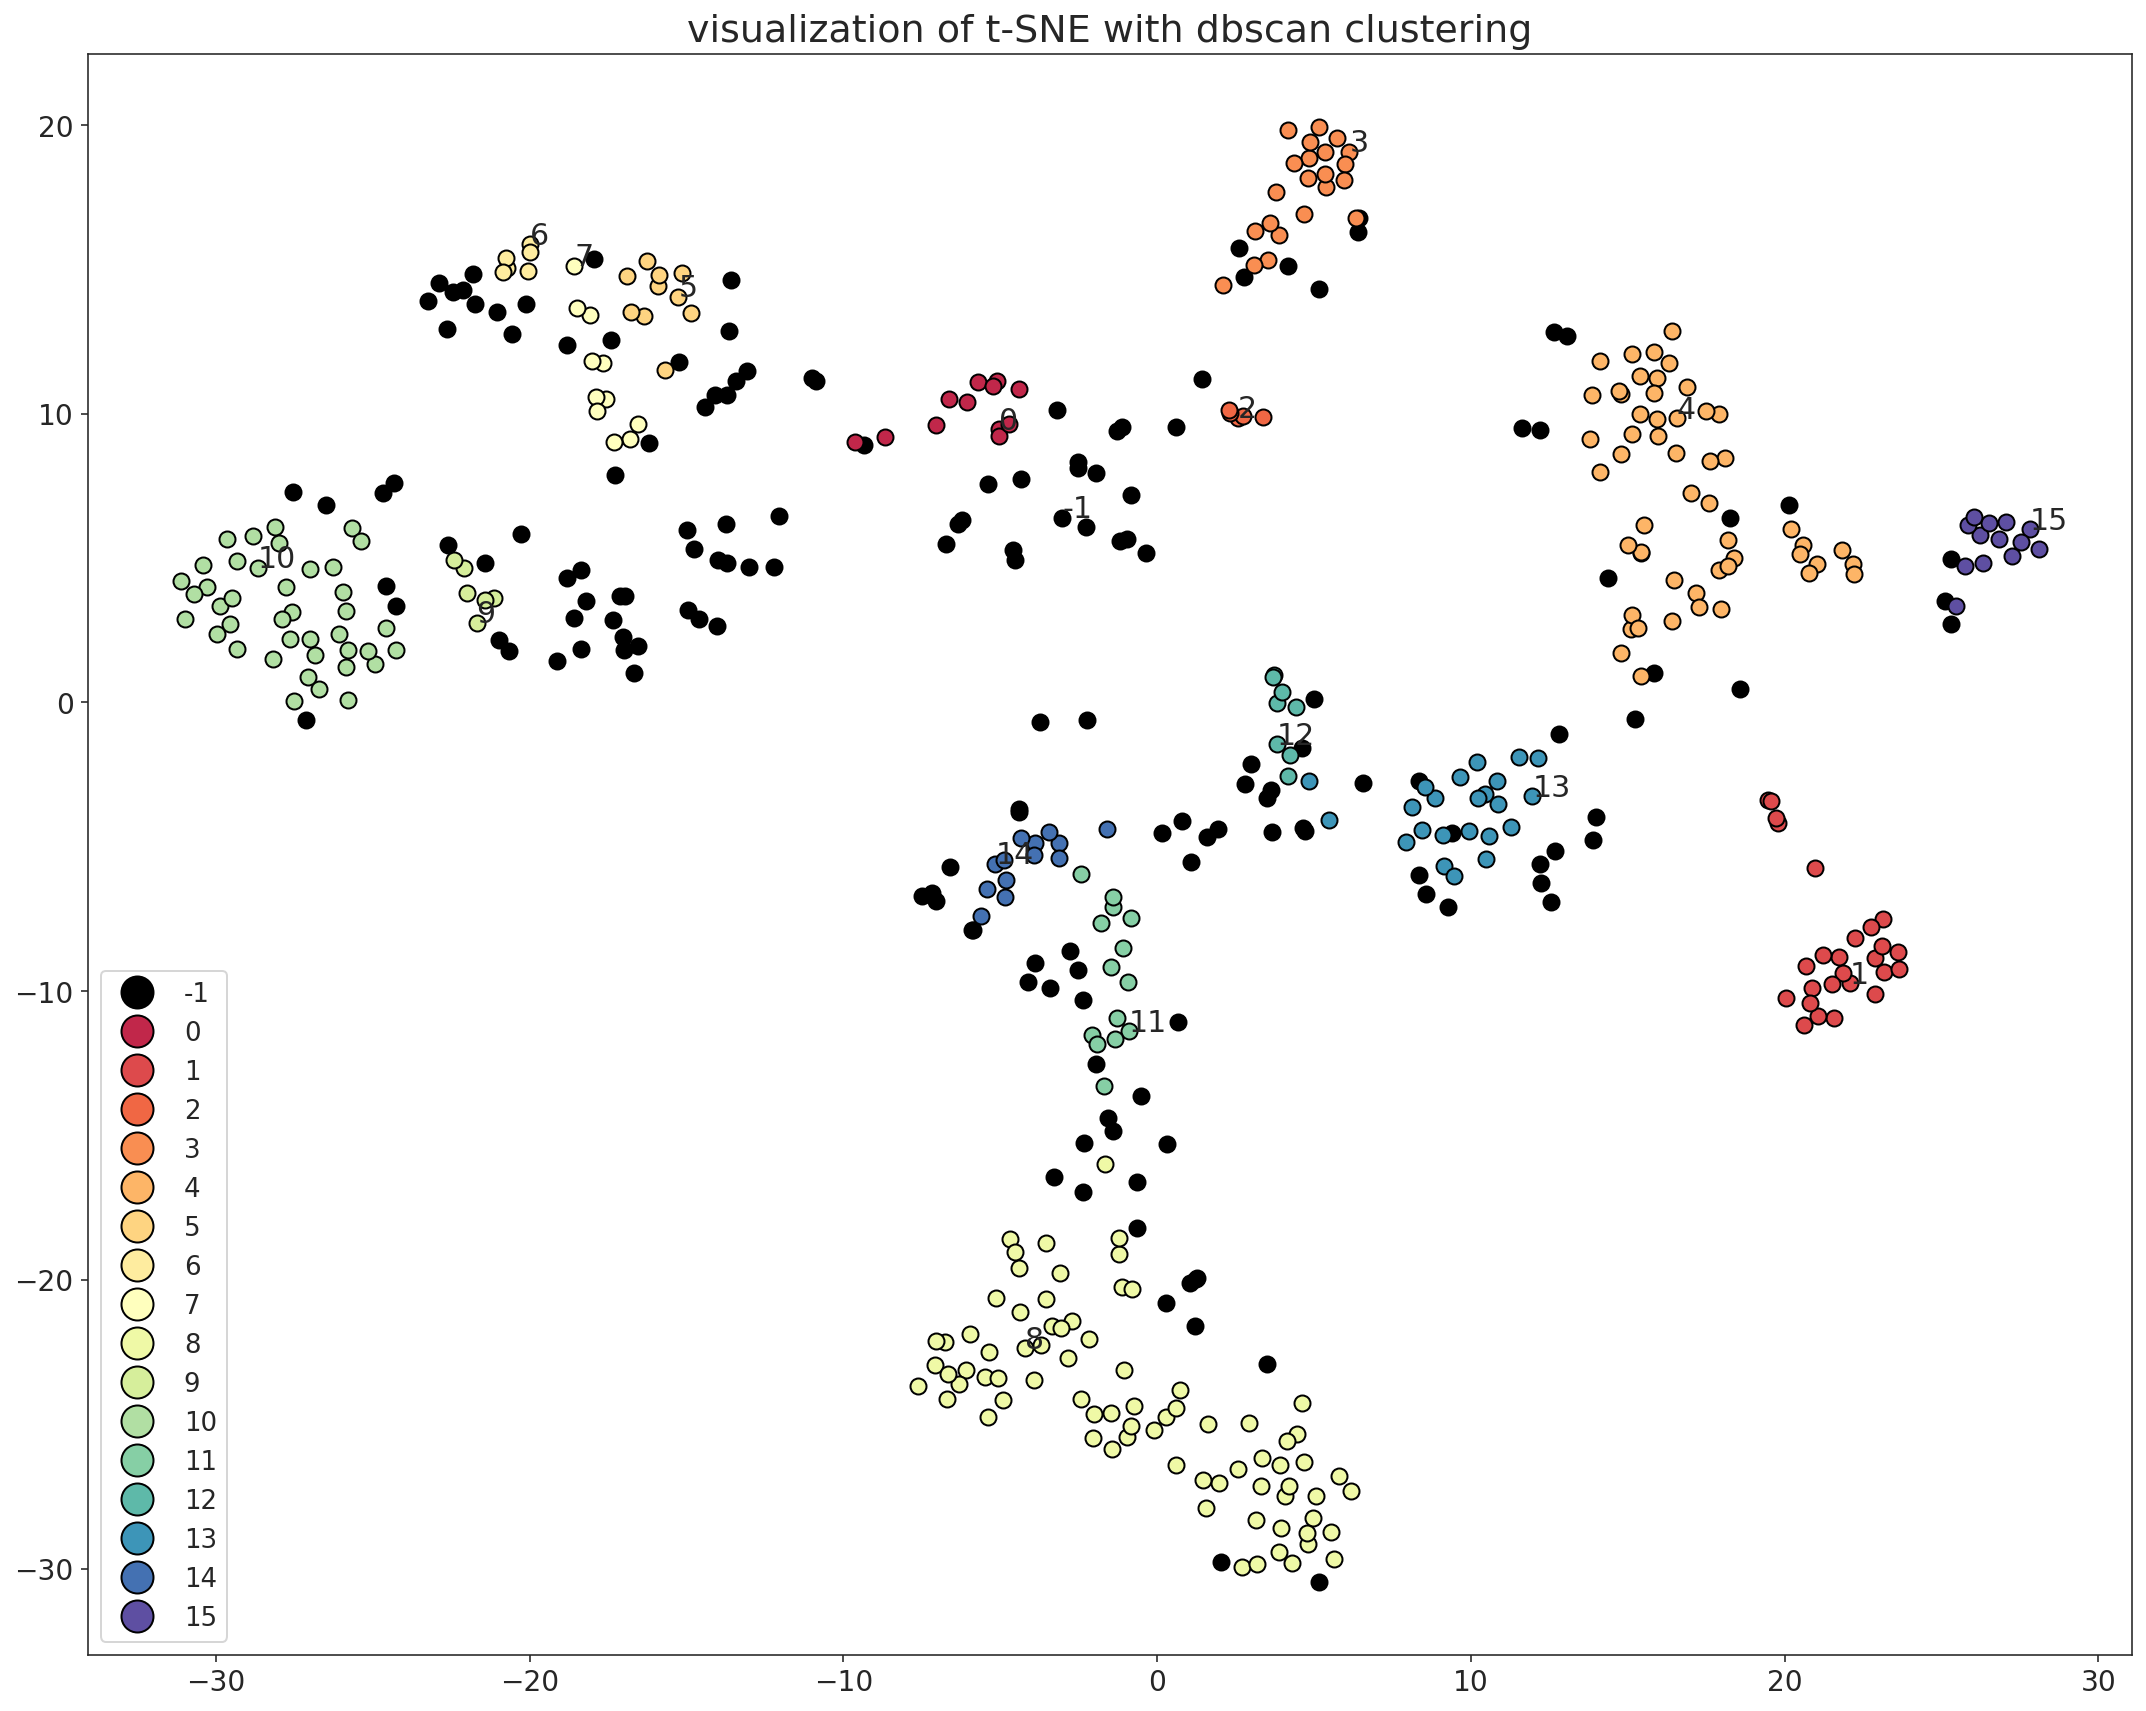

In [131]:
vis_class(X=x_2d, labels=cluster_labels.loc[:, 'cluster_labels'], title='visualization of t-SNE with dbscan clustering')

In [37]:
show_each_md(x_reduced=x_2d_df, frag_info=parallel_frag_info, file_path='figures/abc.png')

### parallel without refragment, molecular vector

In [7]:
parallel_mol2vec = pd.read_csv('../big-data/moses_dataset/result/step4_model_parallel_mol2vec_downsampled.csv', index_col=0, header=None)
print(parallel_mol2vec.shape)
parallel_mol2vec.head(2)

(142067, 100)


1      2      3      4      5      6      7      8      9      10   \
0                                                                           
id6  0.230  4.271 -1.860  3.139  2.185  2.498  2.318  1.343 -0.212  1.851   
id8  0.256  8.870  0.412  2.352  3.176  6.292  0.904  1.206 -0.017 -0.431   

     ...    91     92     93     94     95     96     97     98     99     100  
0    ...                                                                        
id6  ...  7.804  1.818  0.267  3.757 -0.121  3.140  1.682 -2.240 -0.015 -1.227  
id8  ...  9.534  2.898  2.562  2.606  0.781  3.915 -3.332 -2.733  1.892 -2.017  

[2 rows x 100 columns]

In [8]:
# md4class = ['nN', 'nS', 'nO', 'nBondsD', 'naRing', 'nARing']
parallel_mol_info = pd.read_csv('../big-data/moses_dataset/result/mol2md_downsampled.csv', index_col='cid')
print(parallel_mol_info.shape)
# parallel_frag_info = parallel_frag_info.loc[:, md4class].copy()
parallel_mol_info = parallel_mol_info.loc[parallel_mol2vec.index, :].copy()
# parallel_mol_info.drop(columns=['smiles'], inplace=True)
# parallel_mol_info2.drop_duplicates(inplace=True)
parallel_mol_info.head(2)

(142067, 8)


nN  nS  nO  nX  nBondsD  nBondsT  naRing  nARing
0                                                    
id6   1   0   4   1        1        0       1       1
id8   0   0   5   0        1        0       2       0

In [9]:
np.all(parallel_mol2vec.index == parallel_mol_info.index)

True

In [12]:
parallel_mol_info[parallel_mol_info>=1] = 1
list(parallel_mol_info.sum() / parallel_mol_info.shape[0])

[0.8931278903615899,
 0.40259173488565253,
 0.7582549078955704,
 0.4346188770087353,
 0.5010312035870399,
 0.3409166097686303,
 0.9221071747837288,
 0.479682121815763]

In [11]:
def reduce_by_pca(mol2vec):
    pca = PCA(n_components=2, random_state=42)
    x_reduced = pca.fit_transform(mol2vec)
    return x_reduced

In [12]:
pca_95 = PCA(n_components=0.95)
x_reduced_95 = pca_95.fit_transform(parallel_mol2vec)
x_reduced_95.shape

(142067, 9)

In [13]:
x_reduced_95_df = pd.DataFrame(data=x_reduced_95, index=parallel_mol2vec.index)
x_reduced_95_df.head(2)

0         1          2         3         4         5         6  \
0                                                                            
id6 -5.136914 -3.140882   2.858706 -0.877362  0.032839 -0.535869  1.063782   
id8 -8.429123 -4.625877  20.756968 -1.927293  1.105121  4.242228 -0.026945   

            7         8  
0                        
id6 -0.961803 -1.709943  
id8  0.680794  0.347017

In [10]:
x_reduced_95_df.to_csv('../big-data/moses_dataset/result/x_reduced_95%_PCA_parallel_without_refragment_mol2vec.csv', index_label='cid')

In [45]:
# x_2d = reduce_by_tsne(x_reduced_95_df)
x_2d = reduce_by_pca(mol2vec=parallel_mol2vec)

In [15]:
x_2d_df = pd.DataFrame(data=x_2d, index=parallel_mol2vec.index, columns=['x1', 'x2'])
x_2d_df.head(2)

x1        x2
0                      
id6 -5.136914 -3.140882
id8 -8.429123 -4.625877

In [13]:
# x_2d_df.to_csv('../big-data/moses_dataset/result/reduced_by_t-SNE_fragment_without_refragment_mol_vec.csv', index_label='cid')

In [14]:
parallel_mol_info.head(2)

nN  nS  nO  nX  nBondsD  nBondsT  naRing  nARing
0                                                    
id6   1   0   4   1        1        0       1       1
id8   0   0   5   0        1        0       2       0

In [15]:
parallel_mol2vec.head(2)

1      2      3      4      5      6      7      8      9      10   \
0                                                                           
id6  0.230  4.271 -1.860  3.139  2.185  2.498  2.318  1.343 -0.212  1.851   
id8  0.256  8.870  0.412  2.352  3.176  6.292  0.904  1.206 -0.017 -0.431   

     ...    91     92     93     94     95     96     97     98     99     100  
0    ...                                                                        
id6  ...  7.804  1.818  0.267  3.757 -0.121  3.140  1.682 -2.240 -0.015 -1.227  
id8  ...  9.534  2.898  2.562  2.606  0.781  3.915 -3.332 -2.733  1.892 -2.017  

[2 rows x 100 columns]

In [14]:
np.all(parallel_mol_info.index == parallel_mol2vec.index)

True

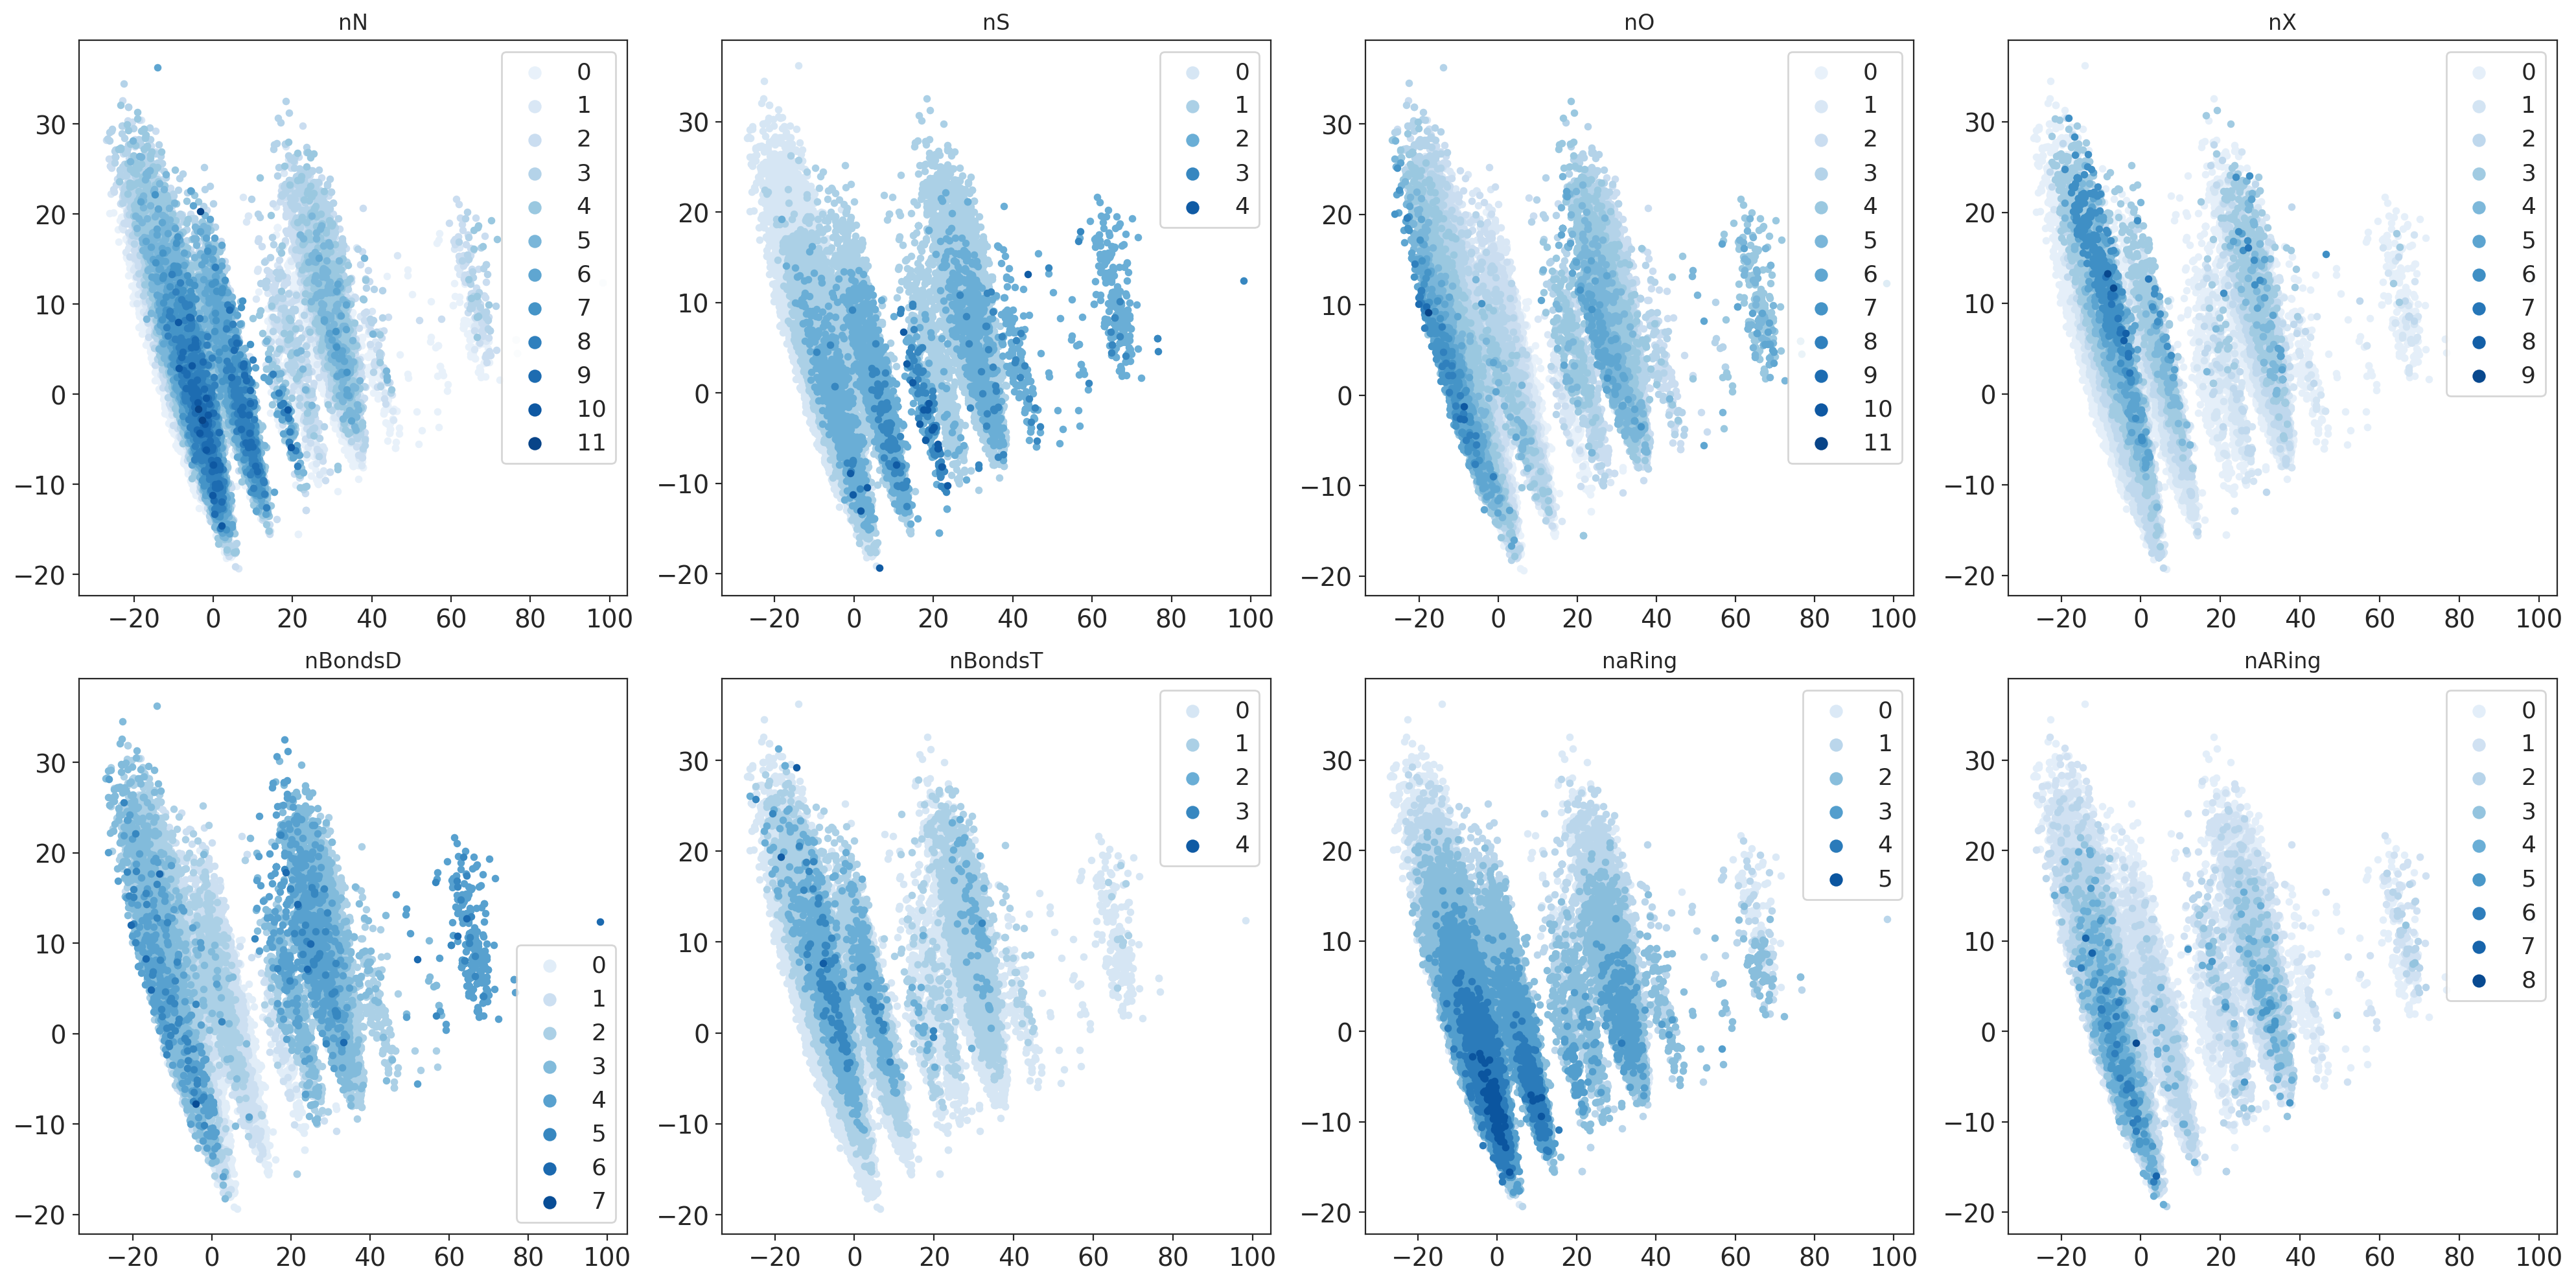

In [16]:
model = 'parallel_without_refragment'
fig, ax = plt.subplots(2, 4, figsize=(20, 10))
ax = ax.flatten()
for i,md in enumerate(parallel_mol_info.columns.to_list()):
    current_labels = parallel_mol_info.iloc[:, i]
    unique_labels = sorted(current_labels.unique())
    n_labels = len(current_labels.unique())
    # print(n_labels)
    cc = sns.color_palette('Blues', n_labels)
    for j,label in enumerate(unique_labels):
        current_nodes = (current_labels == label)
        ax[i].scatter(x_2d[current_nodes, 0], x_2d[current_nodes, 1], c=colors.rgb2hex(cc[j]), vmin=0, vmax=10, s=10, label=str(label))
    ax[i].set_title(md, fontsize=12)
    ax[i].legend()
plt.tight_layout()
# plt.savefig('figures/{}_PCA_by_mol2vec_downsampled_new.png'.format(model), bbox_inches='tight', transparent=True)

In [37]:
x_reduced_95_outlier = x_reduced_95_df.loc[cluster_labels == -1]
x_reduced_95_outlier.head(2)

0         1          2         3         4         5         6  \
0                                                                            
id6 -5.136914 -3.140882   2.858706 -0.877362  0.032839 -0.535869  1.063782   
id8 -8.429123 -4.625877  20.756968 -1.927293  1.105121  4.242228 -0.026945   

            7         8  
0                        
id6 -0.961803 -1.709943  
id8  0.680794  0.347017

In [38]:
x_reduced_95_outlier.shape

(135647, 9)

In [76]:
cluster_labels = cluster_by_dbscan(x=x_reduced_95, min_samples=10, eps=0.15)
# for ms in range(1, 11):
#     for mc in range(2, 21):
#         if mc >= ms:
#             cluster_labels = cluster_by_hdbscan(x=x_reduced_95, min_samples=ms, min_cluster_size=mc)
#             print()

Estimated number of clusters: 428
Estimated number of noise points: 44391


In [91]:
cluster_labels_df = pd.DataFrame(data=cluster_labels, columns=['labels'], index=parallel_mol_info.index)
cluster_labels_df

labels
0                
id6            -1
id8             0
id11            0
id17            0
id24           -1
...           ...
id1584577      -1
id1584601      -1
id1584608       0
id1584657       0
id1584660       0

[142067 rows x 1 columns]

In [82]:
cluster2count = cluster_labels_df['labels'].value_counts().to_dict()
cluster2count

{0: 64710,
 -1: 44391,
 1: 15783,
 2: 8329,
 3: 668,
 14: 159,
 26: 134,
 31: 133,
 85: 129,
 19: 127,
 21: 91,
 17: 88,
 159: 82,
 9: 80,
 68: 78,
 197: 78,
 41: 76,
 38: 71,
 257: 66,
 53: 65,
 7: 64,
 27: 62,
 18: 61,
 261: 55,
 84: 53,
 77: 49,
 75: 48,
 47: 48,
 15: 47,
 23: 47,
 12: 47,
 320: 45,
 394: 45,
 130: 43,
 175: 42,
 141: 42,
 70: 41,
 115: 41,
 109: 41,
 134: 41,
 162: 40,
 124: 40,
 131: 39,
 203: 39,
 172: 38,
 148: 38,
 136: 38,
 253: 37,
 13: 37,
 405: 35,
 50: 35,
 10: 34,
 49: 34,
 174: 34,
 380: 33,
 218: 32,
 98: 32,
 92: 31,
 221: 31,
 213: 31,
 191: 31,
 66: 31,
 209: 31,
 55: 31,
 79: 30,
 153: 30,
 58: 29,
 152: 29,
 169: 28,
 97: 27,
 375: 27,
 247: 27,
 59: 27,
 61: 27,
 133: 27,
 244: 26,
 117: 26,
 339: 25,
 255: 25,
 328: 24,
 161: 24,
 42: 24,
 80: 24,
 354: 24,
 275: 24,
 228: 24,
 308: 24,
 74: 23,
 224: 23,
 33: 23,
 237: 23,
 108: 23,
 107: 23,
 143: 23,
 204: 23,
 160: 23,
 319: 22,
 137: 22,
 69: 22,
 22: 22,
 36: 22,
 60: 21,
 341: 21,
 182: 21

In [84]:
valid_cluster_labels = []
big_cluster_labels = []
for i,j in cluster2count.items():
    if j > 1000:
        big_cluster_labels.append(i)
    else:
        valid_cluster_labels.append(i)

In [86]:
big_cluster_labels, valid_cluster_labels

([0, -1, 1, 2],
 [3,
  14,
  26,
  31,
  85,
  19,
  21,
  17,
  159,
  9,
  68,
  197,
  41,
  38,
  257,
  53,
  7,
  27,
  18,
  261,
  84,
  77,
  75,
  47,
  15,
  23,
  12,
  320,
  394,
  130,
  175,
  141,
  70,
  115,
  109,
  134,
  162,
  124,
  131,
  203,
  172,
  148,
  136,
  253,
  13,
  405,
  50,
  10,
  49,
  174,
  380,
  218,
  98,
  92,
  221,
  213,
  191,
  66,
  209,
  55,
  79,
  153,
  58,
  152,
  169,
  97,
  375,
  247,
  59,
  61,
  133,
  244,
  117,
  339,
  255,
  328,
  161,
  42,
  80,
  354,
  275,
  228,
  308,
  74,
  224,
  33,
  237,
  108,
  107,
  143,
  204,
  160,
  319,
  137,
  69,
  22,
  36,
  60,
  341,
  182,
  88,
  81,
  336,
  195,
  135,
  40,
  356,
  54,
  186,
  155,
  125,
  71,
  227,
  332,
  198,
  245,
  376,
  190,
  123,
  254,
  46,
  225,
  65,
  243,
  129,
  201,
  183,
  202,
  176,
  233,
  91,
  367,
  16,
  147,
  193,
  144,
  294,
  271,
  168,
  145,
  90,
  100,
  34,
  333,
  329,
  114,
  334,
  279,
  249,


In [92]:
valid_cluster2cid = {}
for i in valid_cluster_labels:
    current_cid = cluster_labels_df[cluster_labels_df['labels'] == i].index.to_list()
    valid_cluster2cid['round1_' + str(i)] = current_cid

In [93]:
valid_cluster2cid

{'round1_3': ['id1063',
  'id2586',
  'id2645',
  'id3385',
  'id5150',
  'id6211',
  'id6545',
  'id19243',
  'id25950',
  'id26032',
  'id26033',
  'id27057',
  'id27826',
  'id40429',
  'id44132',
  'id47640',
  'id47868',
  'id56584',
  'id57886',
  'id57893',
  'id58202',
  'id58430',
  'id59234',
  'id72593',
  'id72711',
  'id74105',
  'id74978',
  'id76797',
  'id78235',
  'id79477',
  'id84576',
  'id90524',
  'id91632',
  'id92415',
  'id92703',
  'id92705',
  'id94079',
  'id95979',
  'id96750',
  'id97272',
  'id100616',
  'id100667',
  'id101362',
  'id101753',
  'id101775',
  'id102560',
  'id105175',
  'id105176',
  'id106746',
  'id106747',
  'id106899',
  'id106907',
  'id106972',
  'id107937',
  'id108570',
  'id108572',
  'id108574',
  'id108587',
  'id109377',
  'id109661',
  'id112710',
  'id113383',
  'id113422',
  'id114448',
  'id114772',
  'id114832',
  'id115126',
  'id115220',
  'id119049',
  'id119213',
  'id119605',
  'id119608',
  'id119630',
  'id121089',

In [97]:
cid_in_big_clusters = cluster_labels_df[cluster_labels_df['labels'].isin(big_cluster_labels)].index.to_list()
cid_in_big_clusters

['id6',
 'id8',
 'id11',
 'id17',
 'id24',
 'id27',
 'id28',
 'id35',
 'id36',
 'id42',
 'id48',
 'id53',
 'id55',
 'id57',
 'id60',
 'id67',
 'id70',
 'id73',
 'id75',
 'id76',
 'id88',
 'id91',
 'id99',
 'id100',
 'id101',
 'id118',
 'id131',
 'id146',
 'id149',
 'id162',
 'id167',
 'id168',
 'id173',
 'id177',
 'id182',
 'id186',
 'id190',
 'id200',
 'id205',
 'id210',
 'id250',
 'id252',
 'id256',
 'id260',
 'id263',
 'id265',
 'id288',
 'id307',
 'id311',
 'id314',
 'id321',
 'id344',
 'id355',
 'id410',
 'id444',
 'id478',
 'id590',
 'id592',
 'id663',
 'id690',
 'id739',
 'id748',
 'id777',
 'id871',
 'id895',
 'id963',
 'id965',
 'id981',
 'id1018',
 'id1020',
 'id1021',
 'id1022',
 'id1047',
 'id1052',
 'id1075',
 'id1077',
 'id1091',
 'id1096',
 'id1104',
 'id1106',
 'id1109',
 'id1125',
 'id1130',
 'id1160',
 'id1167',
 'id1189',
 'id1194',
 'id1228',
 'id1250',
 'id1265',
 'id1332',
 'id1345',
 'id1371',
 'id1375',
 'id1377',
 'id1378',
 'id1379',
 'id1387',
 'id1389',
 'id

In [101]:
parallel_mol2vec[parallel_mol2vec.index.isin(cid_in_big_clusters)].head(2)

1      2      3      4      5      6      7      8      9      10   \
0                                                                           
id6  0.230  4.271 -1.860  3.139  2.185  2.498  2.318  1.343 -0.212  1.851   
id8  0.256  8.870  0.412  2.352  3.176  6.292  0.904  1.206 -0.017 -0.431   

     ...    91     92     93     94     95     96     97     98     99     100  
0    ...                                                                        
id6  ...  7.804  1.818  0.267  3.757 -0.121  3.140  1.682 -2.240 -0.015 -1.227  
id8  ...  9.534  2.898  2.562  2.606  0.781  3.915 -3.332 -2.733  1.892 -2.017  

[2 rows x 100 columns]

In [61]:
parallel_mol_info[cluster_labels==5]

nN  nS  nO  nX  nBondsD  nBondsT  naRing  nARing
0                                                          
id636799    1   1   1   1        0        0       1       0
id1260416   2   0   1   1        0        0       1       0
id1474953   2   0   1   1        0        0       1       1
id1475170   2   0   1   1        0        0       1       1
id1531594   2   0   1   2        0        0       2       0
id1531603   2   0   1   2        0        0       2       0

In [27]:
# minibatch_kmeans = MiniBatchKMeans(n_clusters=30)
# minibatch_kmeans.fit(x_reduced_95)

In [24]:
minibatch_kmeans.labels_

array([24,  5,  5, ...,  9,  9,  9], dtype=int32)

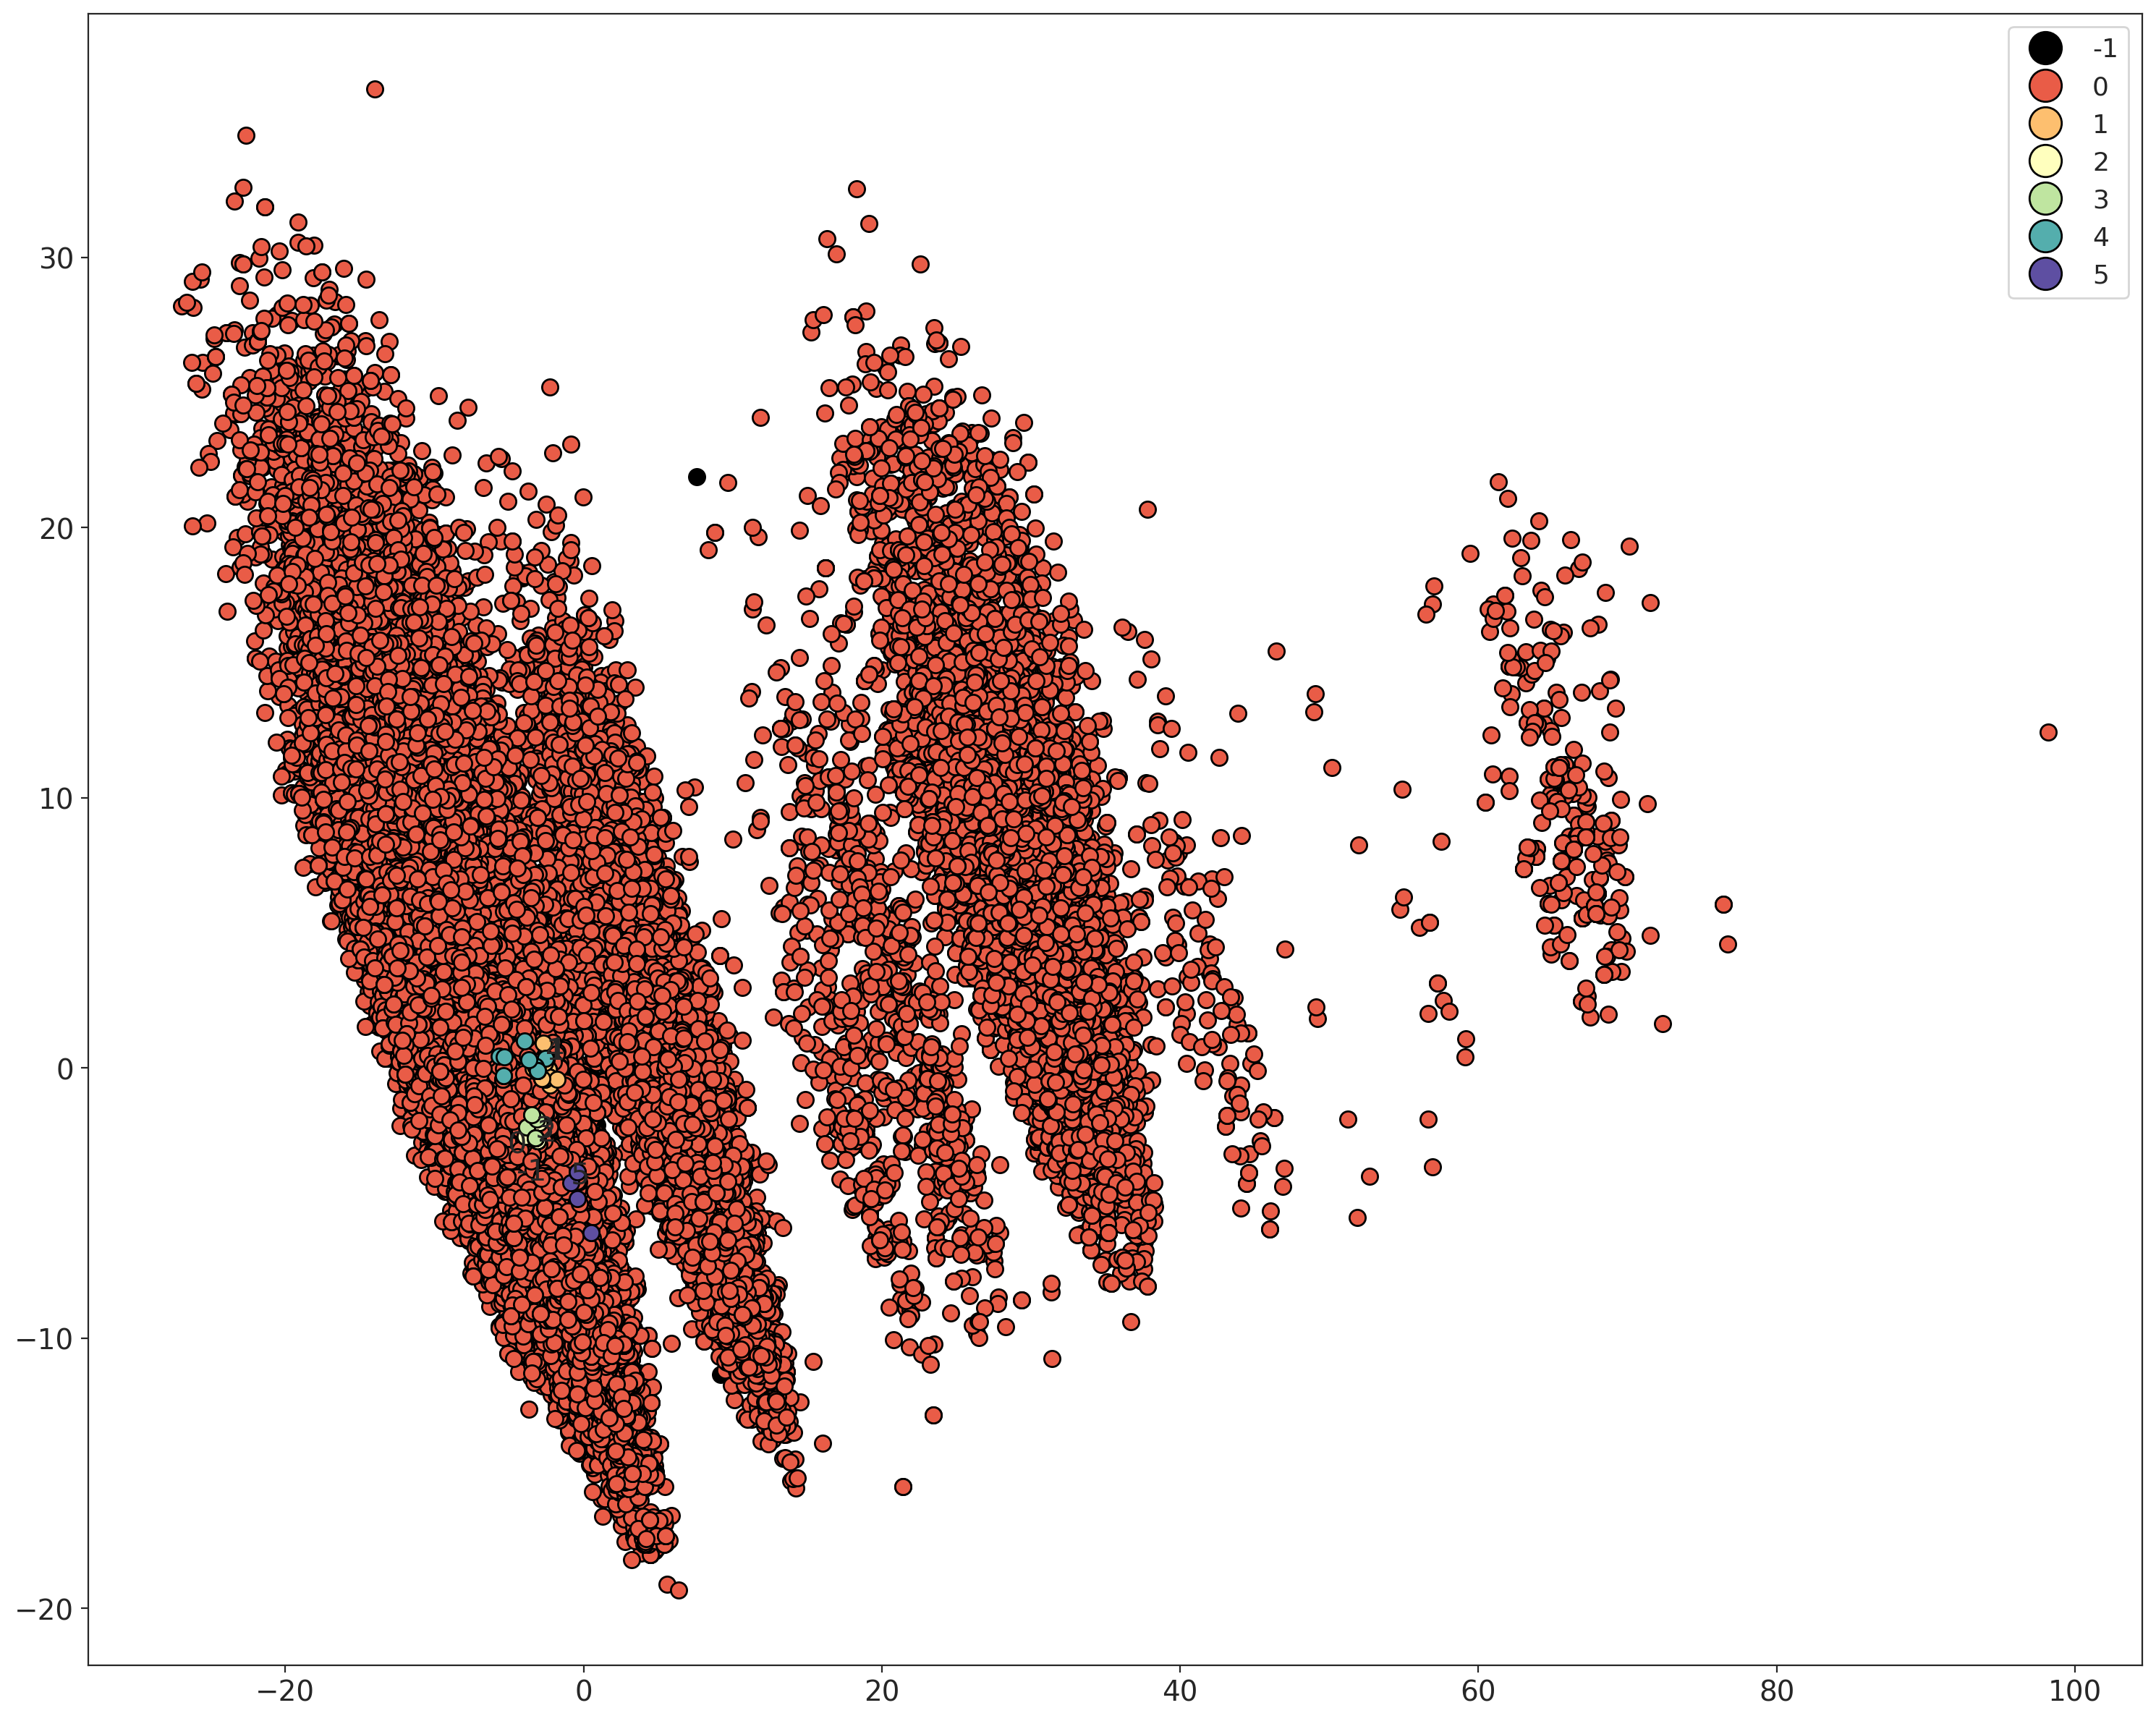

In [51]:
vis_class(X=x_2d, labels=cluster_labels_outlier)

In [26]:
silhouette_score(x_reduced_95, minibatch_kmeans.labels_)

KeyboardInterrupt: 

In [ ]:
cid2labels = pd.DataFrame(data=cluster_labels, index=mol2vec.index, columns=['labels'])
noise = cid2labels[cid2labels['labels'] == -1].index.to_list()
for noi in noise:
    noise_nodes[noi] = 1
cid2labels = cid2labels[cid2labels['labels'] != -1].copy()
cid2labels['count'] = 1
label2num = cid2labels.groupby(['labels']).count()
valid_labels = label2num[label2num['count'] <= 1000]
big_cluster_labels = label2num[label2num['count'] > 1000]


In [ ]:
parall